# Visualizing Climate Change

Author: **Marcin Sikorski**<br>
Date: November, 2022

Global warming is surefire one the most difficult challenge for humanity in the current era and now threatens every aspect of human life. The global mean temperature is gradualy rising and the IPCC estimated at least 2°C of warming by the end of the century.

Since climate change has been urging many large companies, research sites and governments to gather data about our changing planet, there are now giant volumes of data that can be downloaded for free and used for good purpose and general knowledge. In this notebook, we will create map plots and a simple animation of temperature variability with Python.

**Keywords:** global warming, GISTEMP, meteorology, climate change, GIS.

The NASA GISTEMP v4 dataset used for this task is an estimate of global surface temperature change in a gridded monthly structure in netCDF file. The gridded surface contains air temperature anomaly data series on a regular 2°×2° grid. It includes temperatures from 1880 to present on a monthly frequency, and is used by NASA to monitor global and regional climate variability.

**Data Source:** [NASA GISS](https://data.giss.nasa.gov/gistemp/)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# read xarray directly from NASA GISS website
def read_nc_data():
    import urllib.request
    import gzip
    
    url = 'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
    file_handle, _ = urllib.request.urlretrieve(url)

    with gzip.open(file_handle, 'r') as gz_file:
        xr_file = xr.open_dataset(gz_file.read())
        
    return xr_file

xr_df = read_nc_data()

# display dataset outputs
xr_df

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1714, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2022-10-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2022-11-13 11:55:21 by SBBX_to_nc 2.0 - ILAND=1200,...

We will start from plotting a basic chart presenting temperature anomalies for last year.

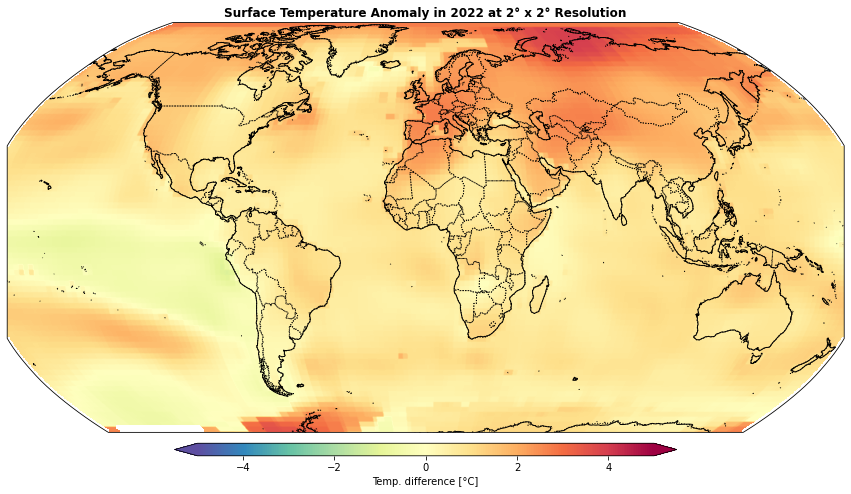

In [3]:
# new xarray with mean values for yearly frequency
climate = xr_df.resample(time='Y').mean()
anomaly = climate['tempanomaly']

# plot for year 2021
def plot_last_year(i=-1):
    from pandas import to_datetime
    
    # colorbar dictionary
    cbar_kwargs = {'orientation': 'horizontal', 'pad': 0.01, 'fraction': 0.4,
                   'aspect': 40, 'shrink': 0.6, 'extend': 'both', 'label': 'Temp. difference [\u00b0C]'}
    
    fig = plt.figure(figsize=(15, 20))
    
    # output projection
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))
    ax.set_extent([-170, 170, -70, 85])
    
    # add map features
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries',
                                                scale='50m', facecolor='none', edgecolor='black', linestyle=':'))
    
    date = to_datetime(anomaly.isel(time=i)['time'].values)
    ax.set_title('Surface Temperature Anomaly in {} at 2\u00b0 x 2\u00b0 Resolution'.format(date.year), weight='bold')
    
    # baseplot
    anomaly.isel(time=i).plot.imshow(ax=ax, add_labels=False, add_colorbar=True, interpolation='quadric',
               vmin=-5, vmax=5, cmap='Spectral_r', transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
    plt.show()
    
plot_last_year()

To visualize a better view of global temperature changes, we will plot submaps for 1960–2010 period. This range will contain 10 year intervals.

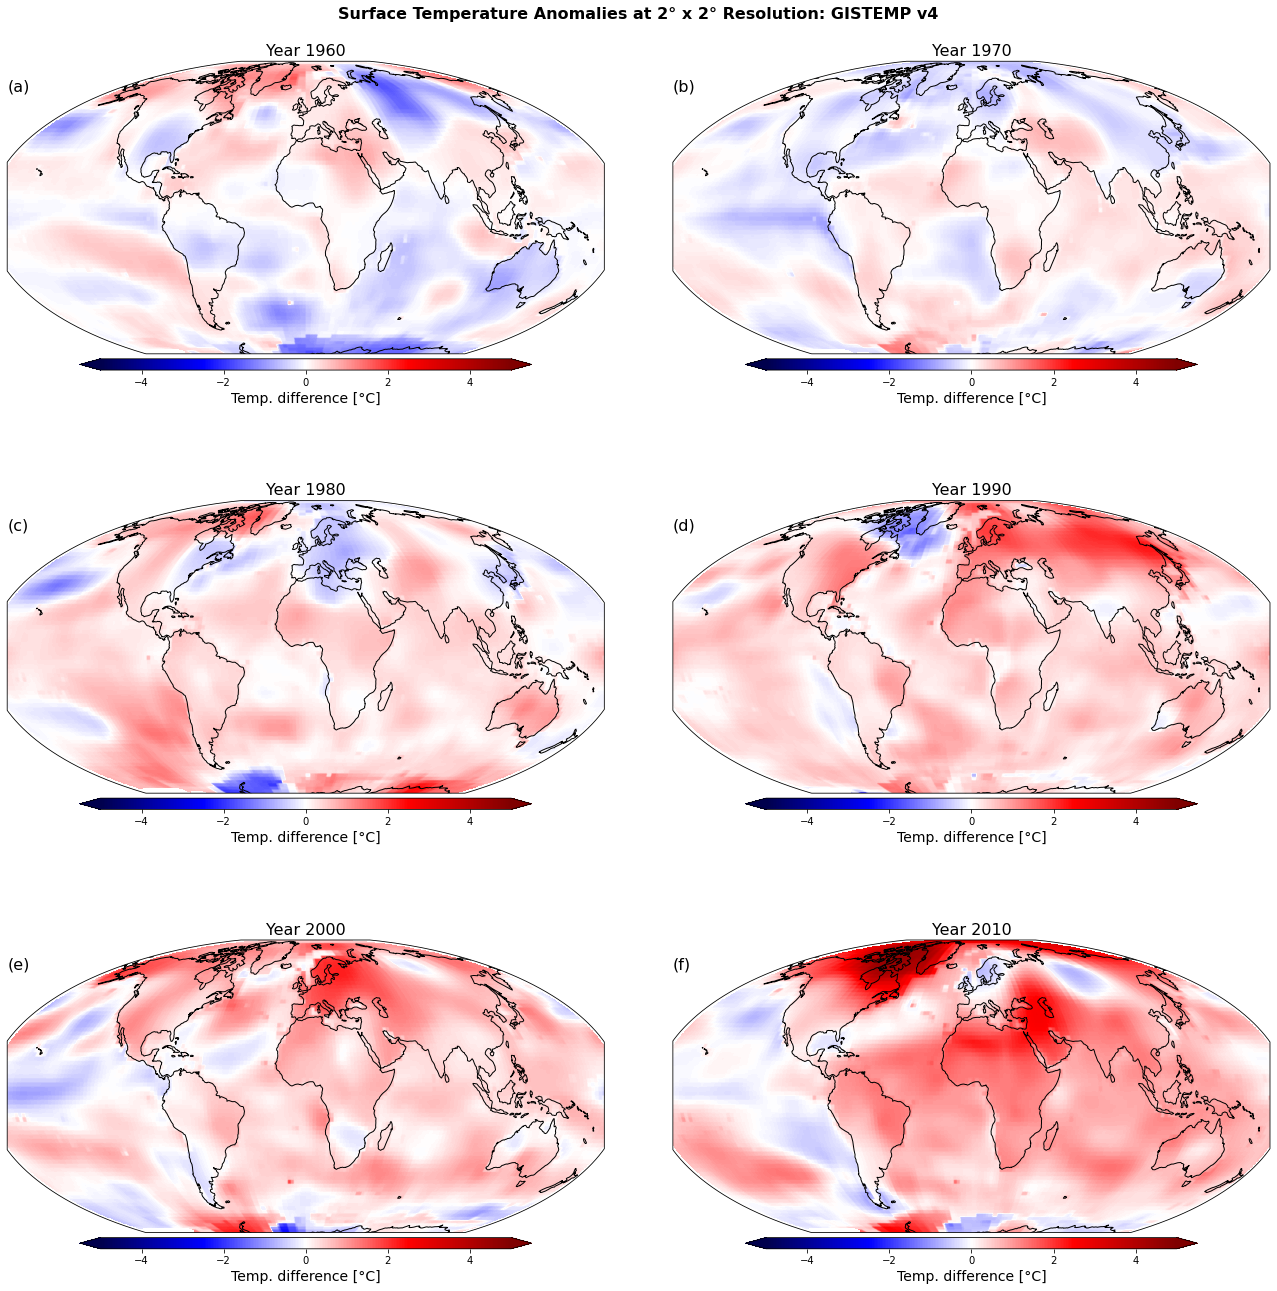

In [4]:
# plots for years: 1960 - 2010 in 10 year intervals
def plot_time_lapse(year_list=range(-63, -12, 10)):
    from pandas import to_datetime
    
    fig, axes = plt.subplots(nrows=3, ncols=2,
                             subplot_kw={'projection': ccrs.Mollweide(central_longitude=0)}, figsize=(20, 20))
    
    # axes is a 2D array of 'GeoAxes' - flatten it into a 1D array
    axes = axes.flatten()
    
    # colorbar dictionary
    cbar_kwargs = {'orientation': 'horizontal', 'pad': 0.01, 'fraction': 0.4, 'aspect': 40, 'shrink': 0.6, 'extend': 'both'}
    
    # loop through year_list
    for i, n in zip(year_list, range(0, 7)):
        date = to_datetime(anomaly.isel(time=i)['time'].values)
        
        # baseplot
        bp = anomaly.isel(time=i).plot.imshow(ax=axes[n], add_labels=False, add_colorbar=False, interpolation='quadric',
               vmin=-5, vmax=5, cmap='seismic', transform=ccrs.PlateCarree())
        
        # title for each subplot
        axes[n].set_title('Year {}'.format(date.year), size=16)
        
        # add colorbar
        fig.colorbar(bp, ax=axes[n], **cbar_kwargs).set_label(label='Temp. difference [\u00b0C]', size=14)
        
    from string import ascii_lowercase

    # add map features and label panels
    for n, ax in enumerate(axes):
        ax.coastlines(resolution='110m')
        ax.set_extent([-170, 170, -70, 85])

        # subplot labels
        ax.text(x=0, y=0.9, s='({})'.format(ascii_lowercase[n]), transform=ax.transAxes, size=16)

    # add title at the top
    plt.suptitle('Surface Temperature Anomalies at 2\u00b0 x 2\u00b0 Resolution: GISTEMP v4', size=16, weight='bold', y=1)

    plt.tight_layout()
    plt.show()
    
plot_time_lapse()

So far we generated static charts presenting global surface temperature changes. Polar regions and land areas are expected to see the largest temperature changes.

In the last step, we will create a simple GIF animation displaying time lapse change through out the 1980–2010 period. The output file will be generated from a collection of images. Each frame of the animation shows a single year. The area of interest will be Greenland. The ice coating of this island is constantly melting, especially in the north-west.

In [5]:
import os

# plots for years: 1980 - 2010
def generate_images(year_list=range(-43, -12)):
    from pandas import to_datetime
    from PIL import Image
    
    # create new folder for plots
    png_path = os.getcwd() + '/images'
    if not os.path.exists(png_path):
        os.makedirs(png_path)
        
    # colorbar dictionary
    cbar_kwargs = {'orientation': 'horizontal', 'pad': 0.01, 'fraction': 0.4,
                   'aspect': 40, 'shrink': 0.6, 'extend': 'both', 'label': 'Temp. difference [\u00b0C]'}
    
    # loop through year_list
    try: 
        for i in year_list: 
            fig = plt.figure(figsize=(6, 5))
    
            # output projection
            ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-45, central_latitude=80))
            ax.set_extent([-90, 0, 85, 55], ccrs.PlateCarree())
    
            # add map features
            ax.coastlines(resolution='50m')
    
            date = to_datetime(anomaly.isel(time=i)['time'].values)
            ax.set_title("Greenland's Surface Anomaly in {}".format(date.year))
    
            # baseplot
            anomaly.isel(time=i).plot.imshow(ax=ax, add_labels=False, add_colorbar=True, vmin=-5, vmax=5,
                    cmap='coolwarm', interpolation='quadric', transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
    
            # save plot in new folder
            plt.savefig(fname='images\year_{}.png'.format(date.year), dpi=200, transparent=True)
            plt.close()
            
            # read plot and crop it
            im_ = Image.open('images\year_{}.png'.format(date.year))
            image = im_.crop((275, 60, 965, 695))
            
            # overwrite with cropped plot
            image.save('images\year_{}.png'.format(date.year))
            
    except:
        print('Some interruption occurred')
    else:
        print('Images ready')

generate_images()

Images ready


In [6]:
# create GIF file from images
def create_gif():
    import imageio

    png_path = os.getcwd() + '/images'
    images = []
    
    # create list of images
    for file_name in sorted(os.listdir(png_path)):
        if file_name.endswith('.png'):
            file_path = os.path.join(png_path, file_name)
            images.append(imageio.imread(file_path))

    # pause at the end
    for _ in range(5):
        images.append(imageio.imread(file_path))

    imageio.mimsave('greenland.gif', images, fps=2)
    
create_gif()

![time_lapse](greenland.gif 'greenland')

### Conclusion

The target of this notebook was to visualize our globe's climate changing. We used grid data distributed as NC files (netCDF's format used for storing multidimensional data) from a reputable organization to plot results. The final products of this repository are: time lapse static maps and a simple animation in GIF format. It is undeniable that Earth's climate is constantly increasing.

There are lots of BI tools nowadays, but Python is still an excellent tool to visualise data. It is very versatile and offers many possibilities for the user to read plenty types of data quickly and in a meaningful way. It is also efficient in reading unstructured data. Another advantage of Python is that it is open source and does not require expensive software, which makes climate data analysis more accessible to everyone.